In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 读取数据

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
IDtest = test["PassengerId"]

print("train: ", train.shape)
print("test: ", test.shape)

train:  (891, 12)
test:  (418, 11)


# 数据校验

In [3]:
# 此函数用于寻找极端数值
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

/home/leon/.conda/envs/test_env/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
print("before: ", train.shape)
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
print("after: ", train.shape)

before:  (891, 12)
after:  (881, 12)


In [6]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
print("dataset: ", dataset.shape)

dataset:  (1299, 12)


/home/leon/.conda/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 特征分析

### 数值型的特征

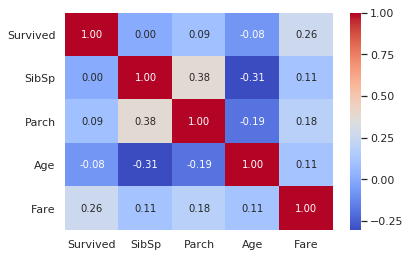

In [12]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

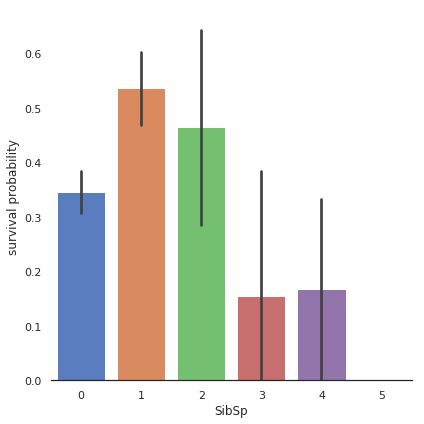

In [13]:
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

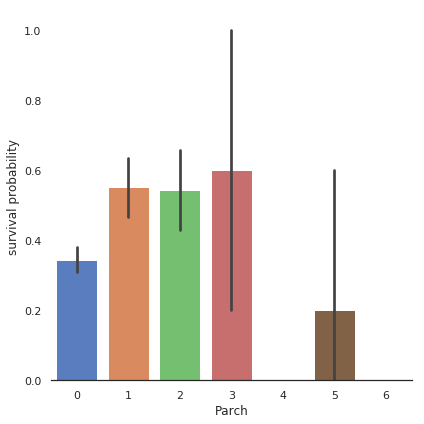

In [14]:
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

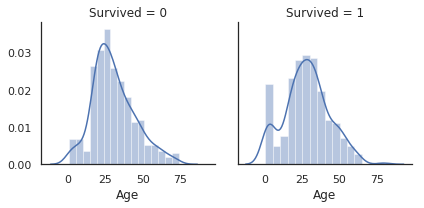

In [15]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

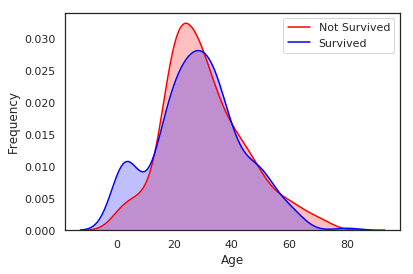

In [16]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

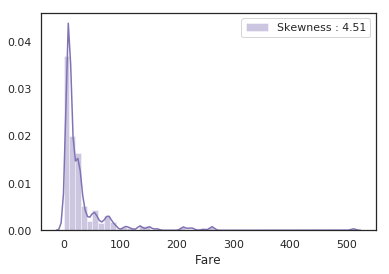

In [19]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [20]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

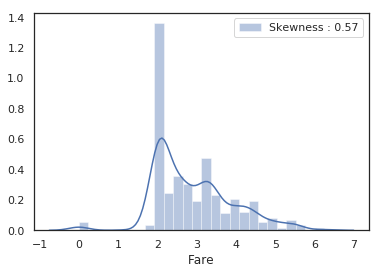

In [21]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

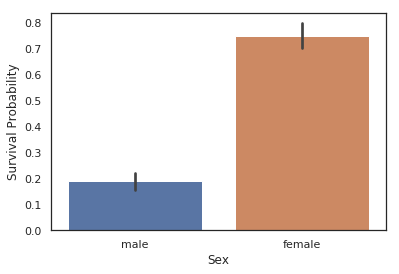

In [22]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

### 类别型的特征

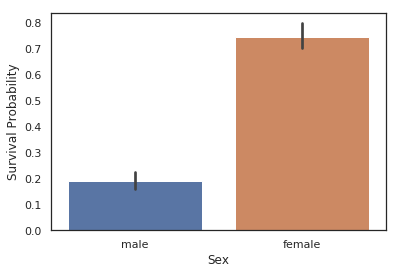

In [23]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [24]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


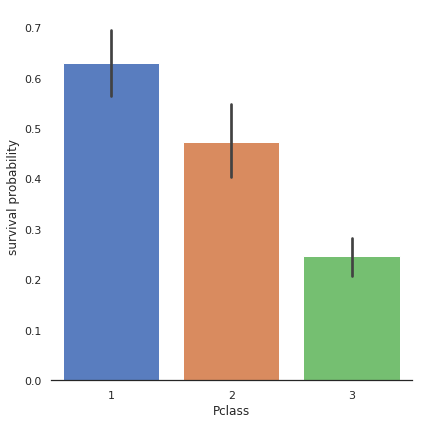

In [25]:
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", height=6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

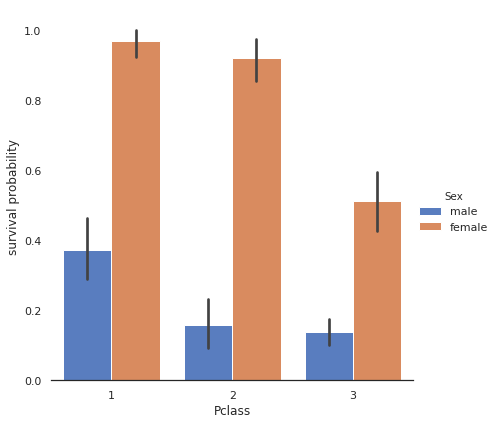

In [26]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [27]:
dataset["Embarked"].isnull().sum()

2

In [28]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

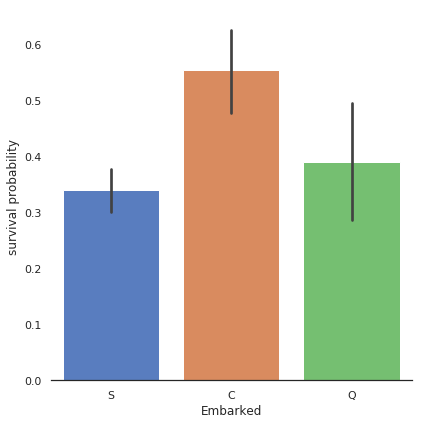

In [29]:
g = sns.catplot(x="Embarked", y="Survived",  data=train, height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

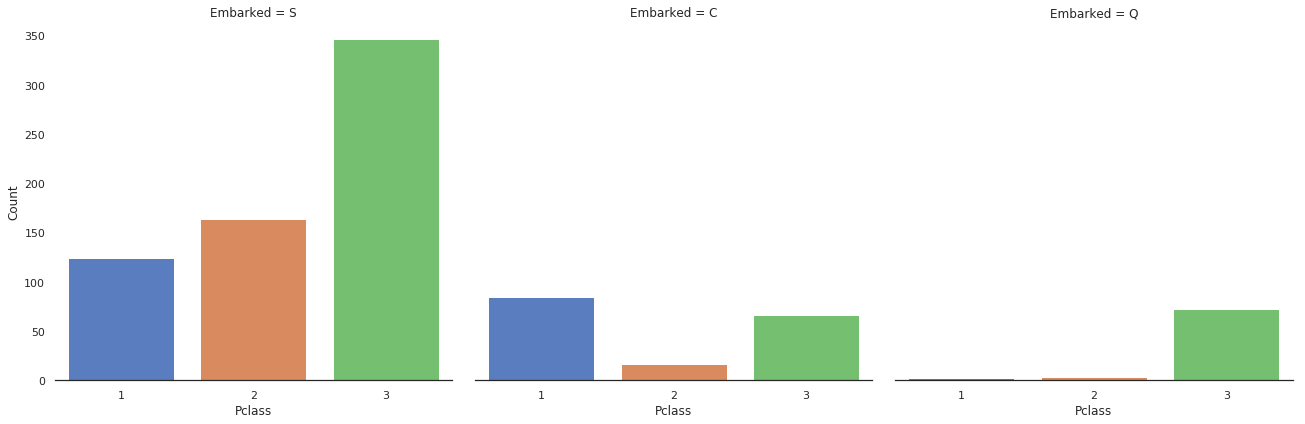

In [30]:
g = sns.catplot("Pclass", col="Embarked",  data=train, height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

# 填充空值

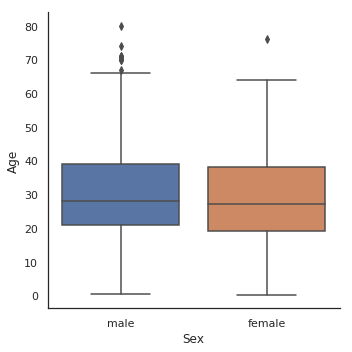

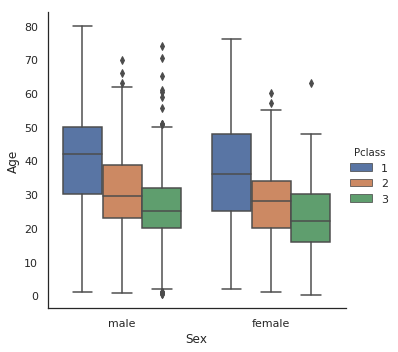

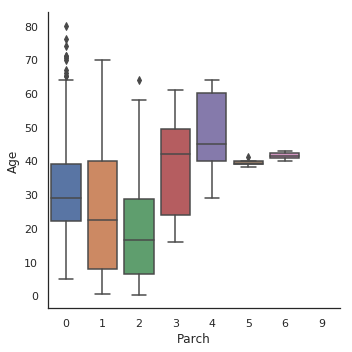

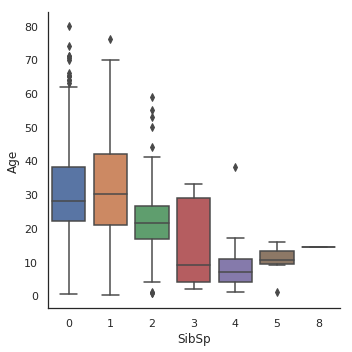

In [31]:
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

In [32]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

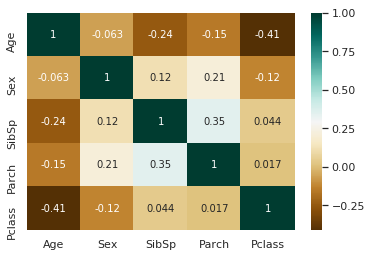

In [33]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [34]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/home/leon/.conda/envs/test_env/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/leon/.conda/envs/test_env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


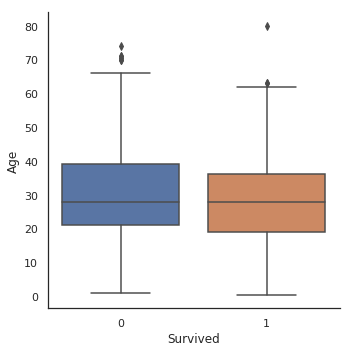

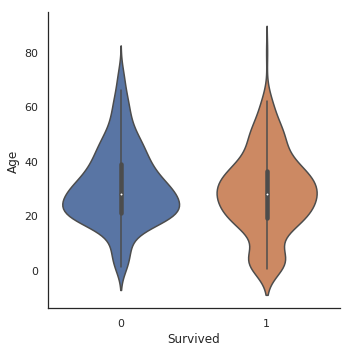

In [35]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

# 特征工程

In [36]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [37]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

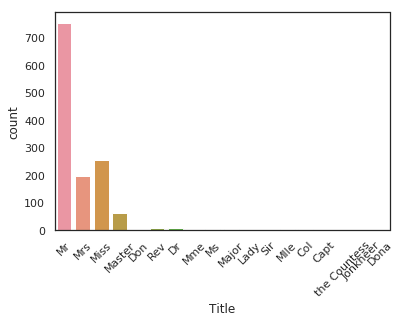

In [38]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [39]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

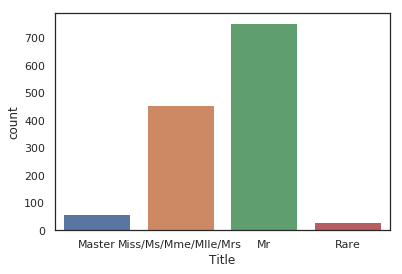

In [40]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

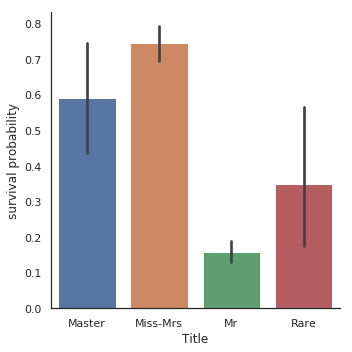

In [41]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [42]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [43]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/home/leon/.conda/envs/test_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


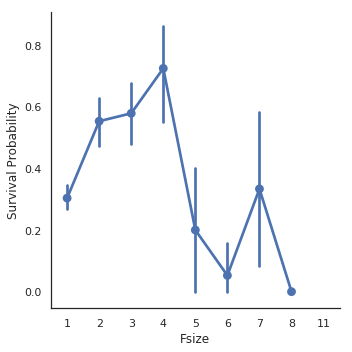

In [44]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

In [45]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

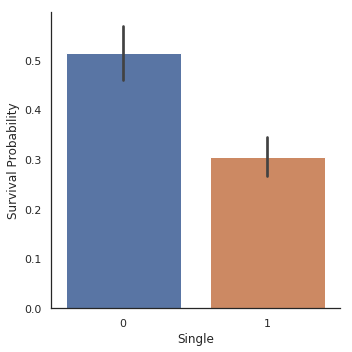

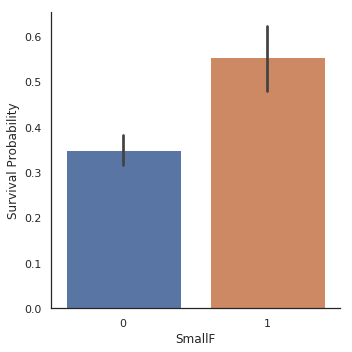

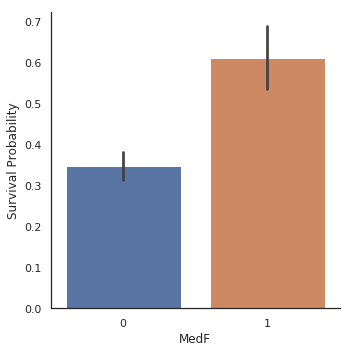

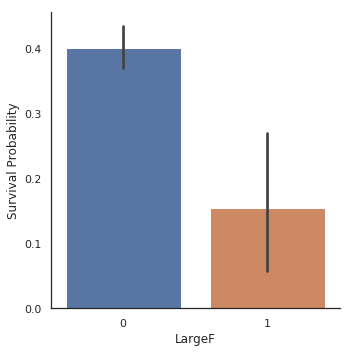

In [46]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [47]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [48]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


In [49]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [51]:
dataset["Cabin"].isnull().sum()

1007

In [52]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

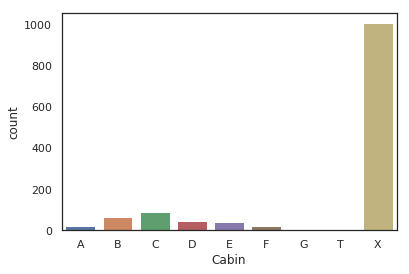

In [54]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

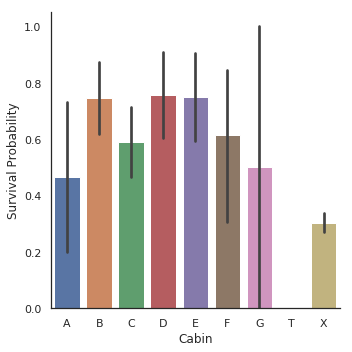

In [55]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [56]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [57]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [58]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [60]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [61]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [62]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 模型

In [63]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/home/leon/.conda/envs/test_env/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [64]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

/home/leon/.conda/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

nn = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(.5),
#    Dense(128, activation='relu'),
#    Dropout(.5),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train, Y_train, epochs=500, batch_size=X_train.shape[0])

score_train_nn = nn.evaluate(X_train, Y_train)[1]
#score_val_nn = nn.evaluate(X_val_imputed, y_val)[1]
y_pred_nn = nn.predict(test)
y_pred_nn = [1 if x > 0.5 else 0 for x in y_pred_nn]

print("train acc: ", score_train_nn)
#print("val acc: ", score_val_nn)

Using TensorFlow backend.


Epoch 1/500
881/881 [==============================] - 0s 153us/step - loss: 1.3075 - acc: 0.5619
Epoch 2/500
881/881 [==============================] - 0s 3us/step - loss: 1.2521 - acc: 0.5755
Epoch 3/500
881/881 [==============================] - 0s 4us/step - loss: 1.2020 - acc: 0.5687
Epoch 4/500
881/881 [==============================] - 0s 3us/step - loss: 1.2738 - acc: 0.5687
Epoch 5/500
881/881 [==============================] - 0s 3us/step - loss: 1.3295 - acc: 0.5630
Epoch 6/500
881/881 [==============================] - 0s 3us/step - loss: 1.3199 - acc: 0.5778
Epoch 7/500
881/881 [==============================] - 0s 3us/step - loss: 1.2280 - acc: 0.5914
Epoch 8/500
881/881 [==============================] - 0s 3us/step - loss: 1.1886 - acc: 0.5982
Epoch 9/500
881/881 [==============================] - 0s 3us/step - loss: 1.1757 - acc: 0.6141
Epoch 10/500
881/881 [==============================] - 0s 4us/step - loss: 1.1470 - acc: 0.6039
Epoch 11/500
881/881 [===============

Epoch 86/500
881/881 [==============================] - 0s 3us/step - loss: 0.5241 - acc: 0.7889
Epoch 87/500
881/881 [==============================] - 0s 3us/step - loss: 0.4904 - acc: 0.7911
Epoch 88/500
881/881 [==============================] - 0s 3us/step - loss: 0.5008 - acc: 0.7889
Epoch 89/500
881/881 [==============================] - 0s 2us/step - loss: 0.4746 - acc: 0.7957
Epoch 90/500
881/881 [==============================] - 0s 2us/step - loss: 0.4846 - acc: 0.7934
Epoch 91/500
881/881 [==============================] - 0s 3us/step - loss: 0.4755 - acc: 0.7798
Epoch 92/500
881/881 [==============================] - 0s 3us/step - loss: 0.4754 - acc: 0.7968
Epoch 93/500
881/881 [==============================] - 0s 3us/step - loss: 0.4884 - acc: 0.8014
Epoch 94/500
881/881 [==============================] - 0s 3us/step - loss: 0.4725 - acc: 0.7980
Epoch 95/500
881/881 [==============================] - 0s 3us/step - loss: 0.4784 - acc: 0.7866
Epoch 96/500
881/881 [========

Epoch 170/500
881/881 [==============================] - 0s 3us/step - loss: 0.4048 - acc: 0.8309
Epoch 171/500
881/881 [==============================] - 0s 2us/step - loss: 0.3963 - acc: 0.8331
Epoch 172/500
881/881 [==============================] - 0s 2us/step - loss: 0.4027 - acc: 0.8331
Epoch 173/500
881/881 [==============================] - 0s 3us/step - loss: 0.4091 - acc: 0.8252
Epoch 174/500
881/881 [==============================] - 0s 3us/step - loss: 0.3977 - acc: 0.8309
Epoch 175/500
881/881 [==============================] - 0s 3us/step - loss: 0.3865 - acc: 0.8434
Epoch 176/500
881/881 [==============================] - 0s 3us/step - loss: 0.3996 - acc: 0.8377
Epoch 177/500
881/881 [==============================] - 0s 3us/step - loss: 0.4012 - acc: 0.8365
Epoch 178/500
881/881 [==============================] - 0s 3us/step - loss: 0.4097 - acc: 0.8309
Epoch 179/500
881/881 [==============================] - 0s 3us/step - loss: 0.4000 - acc: 0.8286
Epoch 180/500
881/88

Epoch 254/500
881/881 [==============================] - 0s 3us/step - loss: 0.3673 - acc: 0.8456
Epoch 255/500
881/881 [==============================] - 0s 3us/step - loss: 0.3747 - acc: 0.8445
Epoch 256/500
881/881 [==============================] - 0s 3us/step - loss: 0.3710 - acc: 0.8456
Epoch 257/500
881/881 [==============================] - 0s 3us/step - loss: 0.3639 - acc: 0.8502
Epoch 258/500
881/881 [==============================] - 0s 3us/step - loss: 0.3790 - acc: 0.8468
Epoch 259/500
881/881 [==============================] - 0s 3us/step - loss: 0.3737 - acc: 0.8445
Epoch 260/500
881/881 [==============================] - 0s 3us/step - loss: 0.3759 - acc: 0.8479
Epoch 261/500
881/881 [==============================] - 0s 3us/step - loss: 0.3750 - acc: 0.8422
Epoch 262/500
881/881 [==============================] - 0s 3us/step - loss: 0.3731 - acc: 0.8513
Epoch 263/500
881/881 [==============================] - 0s 3us/step - loss: 0.3702 - acc: 0.8388
Epoch 264/500
881/88

Epoch 338/500
881/881 [==============================] - 0s 3us/step - loss: 0.3538 - acc: 0.8490
Epoch 339/500
881/881 [==============================] - 0s 3us/step - loss: 0.3587 - acc: 0.8411
Epoch 340/500
881/881 [==============================] - 0s 3us/step - loss: 0.3511 - acc: 0.8570
Epoch 341/500
881/881 [==============================] - 0s 3us/step - loss: 0.3633 - acc: 0.8490
Epoch 342/500
881/881 [==============================] - 0s 3us/step - loss: 0.3551 - acc: 0.8558
Epoch 343/500
881/881 [==============================] - 0s 3us/step - loss: 0.3570 - acc: 0.8479
Epoch 344/500
881/881 [==============================] - 0s 3us/step - loss: 0.3536 - acc: 0.8513
Epoch 345/500
881/881 [==============================] - 0s 3us/step - loss: 0.3495 - acc: 0.8468
Epoch 346/500
881/881 [==============================] - 0s 3us/step - loss: 0.3480 - acc: 0.8479
Epoch 347/500
881/881 [==============================] - 0s 3us/step - loss: 0.3625 - acc: 0.8468
Epoch 348/500
881/88

Epoch 422/500
881/881 [==============================] - 0s 2us/step - loss: 0.3418 - acc: 0.8615
Epoch 423/500
881/881 [==============================] - 0s 3us/step - loss: 0.3335 - acc: 0.8706
Epoch 424/500
881/881 [==============================] - 0s 3us/step - loss: 0.3392 - acc: 0.8604
Epoch 425/500
881/881 [==============================] - 0s 3us/step - loss: 0.3403 - acc: 0.8615
Epoch 426/500
881/881 [==============================] - 0s 3us/step - loss: 0.3490 - acc: 0.8502
Epoch 427/500
881/881 [==============================] - 0s 3us/step - loss: 0.3430 - acc: 0.8672
Epoch 428/500
881/881 [==============================] - 0s 3us/step - loss: 0.3517 - acc: 0.8593
Epoch 429/500
881/881 [==============================] - 0s 3us/step - loss: 0.3401 - acc: 0.8524
Epoch 430/500
881/881 [==============================] - 0s 3us/step - loss: 0.3352 - acc: 0.8627
Epoch 431/500
881/881 [==============================] - 0s 3us/step - loss: 0.3442 - acc: 0.8570
Epoch 432/500
881/88

In [68]:
from xgboost import XGBClassifier

xgbr = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
xgbr.fit(X_train, Y_train)
score_train_xgbr = xgbr.score(X_train, Y_train)
#score_val_xgbr = xgbr.score(X_val_imputed, y_val)
y_pred_xgbr = xgbr.predict(test)

print("train acc: ", score_train_xgbr)
#print("val acc: ", score_val_xgbr)

train acc:  0.9023836549375709


In [69]:
submission = pd.DataFrame({
        "PassengerId": IDtest,
        "Survived": y_pred_xgbr
    })
submission.to_csv('submission.csv', index=False)

In [ ]:
kfold = StratifiedKFold(n_splits=10)

In [ ]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

In [ ]:
gsadaDTC.best_score_

In [ ]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

In [ ]:
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [ ]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)


In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("submission.csv",index=False)